# 1. Fetch data (pl skip running code under the section since I've saved all data fetched from Twitter, otherwise all results will be different)

## Fetch tweets with opioid-related key words

In [2]:
import tweepy
import csv
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import ngrams
from nltk.stem import PorterStemmer
from collections import defaultdict

consumer_key = "bVJILv2OcmijEgLbnYh4x3GuG"
consumer_secret = "T3IAvXHrjeHI7nL8mNDLlhulVpbmuBVuTkHeBsgQgHA21JyRQG"
access_token = "706715585648971776-FC8ZR5kwZIhvNTQDlAqNvJodxAV5vrm"
access_token_secret = "TLT3OsjPN7ybQiVUPwFrf7WvikOtzltTJ32VKPmMylJSk"

# Creating the authentication object
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
# Setting your access token and secret
auth.set_access_token(access_token, access_token_secret)
# Creating the API object while passing in auth information
api = tweepy.API(auth, wait_on_rate_limit=True)

##############################
# Global variables
##############################

count_for_query = 100   # for search, maximum 100
pages_to_query = 1000
count_for_timeline_query = 100    # for query a user's timeline
language = "en"
n_gram_size = 3
training_set_size = 10
most_informative_features_size = 15
top_n_words = 3000

avoid_words = ["https", "News"]
drug_keywords = ["opioid", "codeine", "heroin", "demerol", "dilaudid", "percocet", "fentanyl"]
drug_keywords_variants = ["codine", "herion", "heroine", "demeral", "dilauded", "dilaudud", "dulaudid", "percs", "percocets", "percoset", "fentyl"]
drug_keywords_all = drug_keywords + drug_keywords_variants
# from paper "An Exploration of Social Circles and Prescription Drug Abuse Through Twitter"
abuse_keywords = ["too many", "too much", "overdose", "strong enough", "max", 'alcohol', 'happy pills', 'enough', 'not enough', 'rely', 'stressful', 'stress', 'inject', 'anxiety', 'anxious', 'dizz', 'faint', 'headache', 'shaky']
risk_keywords = abuse_keywords + drug_keywords

# from paper "Comparative Analysis of Patient Distress in Opioid Treatment Programs using Natural Language Processing"
mental_distress_keywords = ["anxiety", "depression", "adhd", "insomnia", "psychiatric disorders", "borderline personality disorder", "ptsd disorders", "substance induced psychological disorders", "dissociative identity disorder", "multiple personality disorder", "panic disorder"]
legal_distress_keywords = ["legal", "problems", "issues", "criminal", "arrest", "prison", "incarcerations"]

##############################
# Data collection from Twitter API
##############################

def query_by_keywords(key_words_all):
    all_tweets = []
    for query in key_words_all:
        query_and_operator = query + " -filter:retweets"
        for page in tweepy.Cursor(api.search_tweets, q=query_and_operator, lang=language, count=count_for_query, tweet_mode='extended').pages(pages_to_query):
            for tweet in page:
                # print("======")
                # print("user: ", tweet.user.screen_name, tweet.user.id)
                # print("created: ", tweet.created_at)
                # print("Tweeted:", tweet.full_text)
                all_tweets.append(tweet)
    filtered_tweets = []
    for tweet in all_tweets: 
        if all([avoid_word not in tweet.full_text for avoid_word in avoid_words]):
            filtered_tweets.append(tweet)
    return filtered_tweets


def query_all_tweets_by_username(api, user_name):
    return api.user_timeline(screen_name=user_name, count=count_for_timeline_query, tweet_mode='extended', include_rts=False)


def filter_by_key_words(tweets, keywords):
    filtered_tweets = []
    for tweet in tweets:
        words = set(word_tokenize(tweet.full_text))
        if any([keyword in words for keyword in keywords]):
            filtered_tweets.append(tweet)
    return filtered_tweets


def get_users_abuse_related_history(api, users):
    filtered_tweets = []
    for user_name in users:
        all_tweets_from_user = query_all_tweets_by_username(api, user_name)
        filtered_tweets += filter_by_key_words(all_tweets_from_user, abuse_keywords)
        print("N of tweets on opioid || abuse till now", len(filtered_tweets))
    return filtered_tweets


def filter_tweets_by_keywords(input_filename, output_filename, keywords, **threshold):
    filtered_tweets = []
    tweets = open_file(input_filename)
    for user_name, tweet in tweets:
        words = set(word_tokenize(tweet))
        keywords_contained = []
        for keyword in keywords:
            if keyword in words:
                keywords_contained.append(keyword)
        if threshold:
            if len(keywords_contained) >= threshold:
                filtered_tweets.append([user_name, keywords_contained, tweet])
        else:
            filtered_tweets.append([user_name, keywords_contained, tweet])
    filtered_tweets.sort(key = lambda x:len(x[1]), reverse=True)
    filtered_tweets = [[t[0], t[2]] for t in filtered_tweets]
    with open(output_filename, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerows(filtered_tweets)
                

def write_tweets_to_csv(tweets, filename):
    csvFile = open(filename, 'a')
    csvWriter = csv.writer(csvFile)
    for tweet in tweets:
        csvWriter.writerow([tweet.user.screen_name, tweet.full_text.encode('utf-8')])
    csvFile.close()


def write_list_to_csv(users, filename):
    file = open(filename, 'a')
    for user in users:
        file.write(user + '\n')
    file.close()


def write_tuple_to_csv(items, filename):
    csvFile = open(filename, 'a')
    csvWriter = csv.writer(csvFile)
    for item in items:
        csvWriter.writerow([item[0], item[1].encode('utf-8')])
    csvFile.close()

def csv_to_list(filename):
    f = open(filename, 'r')
    file = csv.DictReader(f)
    terms = []
    for col in file:
        terms.append(col['Term'])
    return terms


def open_file(filename):
    with open(filename, newline='') as f:
        reader = csv.reader(f)
        data = list(reader)
        return data

In [3]:
dui_terms = csv_to_list('categories.csv')

In [ ]:
filter_tweets_by_keywords("opioid_tweets(3rd).csv", "dui_filter_tweets_by_keywords(3rd).csv", dui_terms)

## After annotated recovered tweets and addicted/abuse tweets, fetch user timeline (pl don't run as well)

In [4]:
def get_username(filename):
    f = open(filename, 'r')
    file = csv.DictReader(f)
    username = []
    for col in file:
        username.append(col['username'])
    return username

In [5]:
recovered_users = get_username('recovered.csv')
recovered_users

['patricktandoh',
 'HamboneMc',
 'flawdNbrokn',
 'StacyBravo8',
 'rollwthepunches',
 'themoonbase420',
 'lakmustang_kerr',
 'FractalTiger95',
 'flawdNbrokn',
 'theeTiffany3',
 'vintagegalholly',
 'michelle04510',
 'morgana_SSS',
 'SquirrelGives',
 'A_rose_4_Emily',
 'obijacobyblack',
 'smitty64',
 'Twilighteyes36',
 'Mari95701660',
 'KevinGresham',
 'junkie_dr',
 'JimDavi76741044',
 'francis_nayan',
 'Summitrust',
 'Win4DC',
 'aPrincessesdad',
 'NeighborDave89',
 'JamesBr60781836',
 'forbiddenknowin',
 'IstlerMark',
 'jessica_tyciak',
 'RustySwingle',
 'opulantpalace',
 'Heather34028771',
 'PresElectServo',
 'AshleyOneilXXX',
 'BrettRosemann',
 'shanecenters',
 '5theyeYavapai',
 'HeidiB52805817',
 'doopatroop',
 'lilbreon_',
 'Sobercrypto',
 'italiajohnny85',
 'FRDRC_2192',
 'Ariana_trlva',
 'twack_',
 'mel_rose_42',
 'Daleicious98',
 'FeministXxHorns',
 'boiano_drew',
 'UnknownTrev',
 'JoeDirt4Prezi',
 'nashtyboy3x',
 'Oklahomer82',
 'HeidiB52805817',
 'diagne00',
 'Wulfrache',
 'rick

In [7]:
def get_timeline_for_all_users(users):
    tweets = []
    for user_name in users:
        try:
            tweets += query_all_tweets_by_username(api, user_name)
        except Exception:
            pass
    return tweets

recovered_user = get_username('recovered.csv')
recovered_user_tweets = get_timeline_for_all_users(recovered_user)
recovered_tweets_text = text_list(recovered_user_tweets)
print(len(recovered_tweets_text))

abuse_user = get_username('abuse.csv')
abuse_user_tweets = get_timeline_for_all_users(abuse_user)
abuse_tweets_text = text_list(abuse_user_tweets)
print(len(abuse_tweets_text))

8060
6320


In [166]:
print(len(recovered_user))
print(len(abuse_user))

111
87


In [159]:
import pickle
  
with open('recovered_user_tweets.dictionary', 'wb') as r_file:
  pickle.dump(recovered_user_tweets, r_file)

with open('abuse_user_tweets.dictionary', 'wb') as a_file:
  pickle.dump(abuse_user_tweets, a_file)

# 2. User-level sentiment analysis using vader (runnable code starts here)

## Retrive data objects from local file saved earlier

In [5]:
import pickle

def text_list(tweets):
    list = []
    for t in tweets:
        list.append(t.full_text)
    return list

recovered_user_tweets = []
recovered_tweets_text = []
with open('recovered_user_tweets.dictionary', 'rb') as config_dictionary_file:
    recovered_user_tweets = pickle.load(config_dictionary_file)
    recovered_tweets_text = text_list(recovered_user_tweets)
recovered_tweets_text

['@viewist @goal World Cup is in November December they would have voted already',
 '@LilMoGh Real Madrid',
 '@gyaigyimii My guy what’s yur source',
 '@TaittieC @Legendinho1 @FrankKhalidUK @_Burabari @433_cfc Lol and what was the goal pls😂😂😂',
 '@gyaigyimii I Dey start Dey lose respect give u',
 '@InTouchMin Amen 🙏🏻',
 '@salman_natha94 @jakeheasman Should have been 4-0 😂  then the first league should have be 5-1 what a joke 😂😂😂😂😂😂 cry some more',
 '@salman_natha94 @jakeheasman Cried lmfao 🤣 😂😂😂 over a fake corner when 90 minutes at Madrid is like 120 minutes ..go cry some more loser 😂😂😂😂😂',
 '@salman_natha94 @jakeheasman Go cry a river u didn’t even deserve to go to extra time deal wid it',
 '@AceBitz @UtdsMark @ESPNFC And I definitely prefer u crying along wid the Chelsea players coming home 😊',
 '@xtimoziyertz @NizaarKinsella What about his goal did u wish the referee should have saw that it didn’t touch any Madrid player ??',
 '@salman_natha94 @jakeheasman How is it robbery when it 

In [6]:
abuse_user_tweets = []
abuse_tweets_text = []
with open('abuse_user_tweets.dictionary', 'rb') as a_file:
    abuse_user_tweets = pickle.load(a_file)
    abuse_tweets_text = text_list(abuse_user_tweets)
abuse_tweets_text

['@bgdesign @anthonyzenkus Uhhh what. Not seeing it',
 '@ReallyAmerican1 @KMark1969 #RejectOZ',
 '@lilwaltsunicorn @myWitsEnnd @RobWhis73 @PattyMurray As if anyone with a brain would say, Hey, ya. Great idea. I’m going to carry my rapist’s child and put the child up for adoption. No big deal. Then my life is back to joy and happiness. Geezzus. What an ass 🤬',
 '@JulieJulesLamb @Veeshandle @SenatorCollins The dreaded lethal giant rainbow colored chalk. OH MY! The officers risked their lives and should be given a congressional medal. Wow. Such amazing heroes',
 '@JonnyDTyler @MrShadowBadger @HugoAmeliorate @VoteRoyAR “Than” I guess you skipped too many classes',
 '@EnseySherwood Oh no. I can’t even read this 💔💔💔😢',
 '@malika_imani Beautiful 💕💕 I got goosebumps! This made my day',
 '@LMarieVResists This is horrific. And exactly why police reform is necessary. Makes me physically ill',
 '@SATIRE_of_SEVS @wcbuecker I know! It’s some crazy ass shit but it could be true 🤷\u200d♀️',
 '@SunnyDa

## Get sentiment scores of each user

In [10]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import defaultdict


def avg(l):
    return sum(l) / len(l)

def vader_score(sentences):
    analyzer = SentimentIntensityAnalyzer()
    compound = []
    pos = []
    neg = []
    neu = []
    n = len(sentences)
    for sentence in sentences:
        vs = analyzer.polarity_scores(sentence)
        compound.append(vs['compound'])
        pos.append(vs['pos'])
        neg.append(vs['neg'])
        neu.append(vs['neu'])
    return compound, pos, neg, neu

recovered_compound, recovered_pos, recovered_neg, recovered_neu = vader_score(recovered_tweets_text)
avg(recovered_compound)

0.12353599255583148

In [9]:
abuse_compound, abuse_pos, abuse_neg, abuse_neu = vader_score(abuse_tweets_text)
avg(abuse_compound)

0.047155094936709004

In [11]:
def user_text_dict(tweets):
    d = defaultdict(list)
    for t in tweets:
        d[t.user.screen_name].append(t.full_text)
    return d

recovered_dict = user_text_dict(recovered_user_tweets)
recovered_dict

defaultdict(list,
            {'patricktandoh': ['@viewist @goal World Cup is in November December they would have voted already',
              '@LilMoGh Real Madrid',
              '@gyaigyimii My guy what’s yur source',
              '@TaittieC @Legendinho1 @FrankKhalidUK @_Burabari @433_cfc Lol and what was the goal pls😂😂😂',
              '@gyaigyimii I Dey start Dey lose respect give u',
              '@InTouchMin Amen 🙏🏻',
              '@salman_natha94 @jakeheasman Should have been 4-0 😂  then the first league should have be 5-1 what a joke 😂😂😂😂😂😂 cry some more',
              '@salman_natha94 @jakeheasman Cried lmfao 🤣 😂😂😂 over a fake corner when 90 minutes at Madrid is like 120 minutes ..go cry some more loser 😂😂😂😂😂',
              '@salman_natha94 @jakeheasman Go cry a river u didn’t even deserve to go to extra time deal wid it',
              '@AceBitz @UtdsMark @ESPNFC And I definitely prefer u crying along wid the Chelsea players coming home 😊',
              '@xtimoziyert

In [12]:
def get_vs_details(d):
    vs_dict = {}
    for user, sentences in d.items():
        com, pos, neg, neu = vader_score(sentences)
        vs_dict[user] = {}
        vs_dict[user]['com'] = com
        vs_dict[user]['pos'] = pos
        vs_dict[user]['neg'] = neg
        vs_dict[user]['neu'] = neu
    return vs_dict

recovered_dict_vs = get_vs_details(recovered_dict)
recovered_dict_vs

{'patricktandoh': {'com': [0.0,
   0.0,
   0.0,
   0.8957,
   0.1027,
   0.0,
   0.9545,
   0.9578,
   -0.4767,
   0.6808,
   0.4696,
   0.4939,
   0.8807,
   0.0,
   0.4215,
   0.9062,
   0.4939,
   0.4767,
   0.7178,
   0.6036,
   0.1531,
   0.3612,
   0.8957,
   0.0,
   -0.7351,
   0.0,
   0.4019,
   0.8442,
   0.296,
   0.6908,
   0.9089,
   0.9413,
   0.0,
   0.4215,
   0.0,
   0.9406,
   0.0,
   0.872,
   0.0,
   -0.0387,
   0.2732,
   -0.8519,
   0.9867,
   0.6486,
   -0.296,
   0.6908,
   0.0,
   0.3182,
   0.5719,
   0.0,
   -0.2411,
   0.7003,
   0.4404,
   0.4767,
   0.7184,
   0.9074,
   -0.2263,
   0.0772,
   0.2263,
   -0.0465,
   0.1635,
   0.6705,
   0.5859,
   0.5267,
   0.8555,
   -0.7876,
   -0.3612,
   -0.3919,
   0.9711,
   0.4215,
   0.9022,
   0.8555,
   0.1531,
   0.4404,
   0.4391,
   0.9601,
   0.926,
   0.7076,
   0.0],
  'pos': [0.0,
   0.0,
   0.0,
   0.386,
   0.242,
   0.0,
   0.342,
   0.356,
   0.0,
   0.302,
   0.127,
   0.144,
   0.349,
   0.0,
   0.2

In [13]:
def get_mean(d):
    vs_avg_dict = defaultdict(dict)
    for user, cat in d.items():
        for cat, scores in cat.items():
            vs_avg_dict[user][cat] = avg(scores)
    return vs_avg_dict

recovered_avg_vs_dict = get_mean(recovered_dict_vs)
recovered_avg_vs_dict

defaultdict(dict,
            {'patricktandoh': {'com': 0.36638481012658214,
              'pos': 0.2056835443037975,
              'neg': 0.06343037974683542,
              'neu': 0.7308987341772152},
             'HamboneMc': {'com': 0.15536164383561646,
              'pos': 0.14026027397260277,
              'neg': 0.04706849315068493,
              'neu': 0.8126712328767124},
             'flawdNbrokn': {'com': 0.3766409638554217,
              'pos': 0.220289156626506,
              'neg': 0.041819277108433736,
              'neu': 0.7378795180722894},
             'StacyBravo8': {'com': 0.80898,
              'pos': 0.31980000000000003,
              'neg': 0.05600000000000001,
              'neu': 0.624},
             'rollwthepunches': {'com': 0.039736000000000014,
              'pos': 0.17450999999999997,
              'neg': 0.11143999999999997,
              'neu': 0.7140099999999999},
             'lakmustang_kerr': {'com': 0.4234338235294118,
              'pos': 0.3268235

In [14]:
def get_4_vader_lists(avg_dict):
    com_list = []
    pos_list = []
    neg_list = []
    neu_list = []
    for user, cat in avg_dict.items():
        com_list.append(cat['com'])
        pos_list.append(cat['pos'])
        neg_list.append(cat['neg'])
        neu_list.append(cat['neu'])
    return com_list, pos_list, neg_list, neu_list

recovered_com_list, recovered_pos_list, recovered_neg_list, recovered_neu_list = get_4_vader_lists(recovered_avg_vs_dict)
print(avg(recovered_com_list), avg(recovered_pos_list), avg(recovered_neg_list), avg(recovered_neu_list))

0.126033778105738 0.15168663742509664 0.0804515516699378 0.7678642453845235


In [15]:
abuse_dict = user_text_dict(abuse_user_tweets)
abuse_dict_vs = get_vs_details(abuse_dict)
abuse_avg_vs_dict = get_mean(abuse_dict_vs)
abuse_com_list, abuse_pos_list, abuse_neg_list, abuse_neu_list = get_4_vader_lists(abuse_avg_vs_dict)
print(avg(abuse_com_list), avg(abuse_pos_list), avg(abuse_neg_list), avg(abuse_neu_list))

0.04783997346912504 0.12903027326519734 0.09587313782664857 0.7750982231362027


## Plot each user (POS, NEG)

In [16]:
import matplotlib.pyplot as plt
import matplotlib

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}

matplotlib.rc('font', **font)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


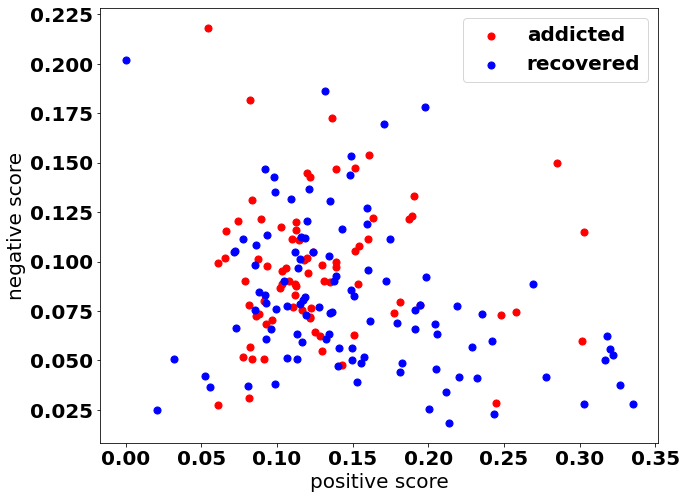

In [17]:
plt.figure(figsize=(10, 8))
plt.scatter(abuse_pos_list, abuse_neg_list, s=50, c='red', label="addicted")
plt.scatter(recovered_pos_list, recovered_neg_list, s=50, c='blue', label="recovered")
plt.xlabel("positive score")
plt.ylabel("negative score")
plt.legend(loc="upper right")
plt.show()

## t-test on 2 groups

In [19]:
import numpy
import pandas as pd
import seaborn as sns
import warnings
from pylab import rcParams
from scipy.stats import f_oneway
from scipy.stats import ttest_ind

np_abuse_com_list = numpy.array(abuse_com_list)
np_recovered_com_list = numpy.array(recovered_com_list)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


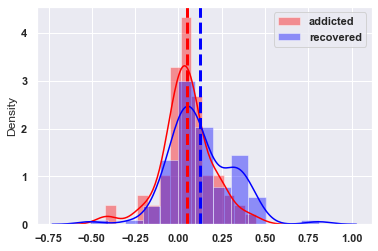

In [49]:
sns.set(font_scale = 1)
ax1 = sns.distplot(np_abuse_com_list, color='red', label="addicted")
ax2 = sns.distplot(np_recovered_com_list, color='blue', label="recovered")
plt.axvline(numpy.mean(np_abuse_com_list), color='red', linestyle='dashed', linewidth=3)
plt.axvline(numpy.mean(np_recovered_com_list), color='blue', linestyle='dashed', linewidth=3)
plt.legend(loc="upper right")

In [26]:
def compare_2_groups(arr_1, arr_2, alpha):
    stat, p = ttest_ind(arr_1, arr_2)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    if p > alpha:
        print('Same distributions (fail to reject H0)')
    else:
        print('Different distributions (reject H0)')
        
compare_2_groups(np_abuse_com_list, np_recovered_com_list, 0.05)

Statistics=-3.072, p=0.002
Different distributions (reject H0)


# 3. Word-level analysis

## Create 2 dataframes for abuse and addicted groups respectively, each row is a tweet
## Tokenize each tweet, get polarity and subjectivity for each tweet

In [27]:
from textblob import TextBlob
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

def subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def polarity(text):
    return TextBlob(text).sentiment.polarity

def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'#', '', text)
    text = text.replace('&amp;', '')
    return text

stop_words = set(stopwords.words("english"))
sentence = "Let's test the n-grams implementation with this sample sentence! Yay!"
ps = PorterStemmer()

def tokenize(text):
    words = word_tokenize(text)
    # to lower string
    words = [w.lower() for w in words]
    # remove stopwords
    words = [w for w in words if w not in stop_words]
    # remove punctuation
    words = [w for w in words if w not in """-<“(:?!\/?a(?=>|\s.*>))\/?.*>[\…\”\'\’\`\,\(\)\"\\]"""]
    # stemming
    #     words = [ps.stem(w) for w in words]
    print(words)
    return words

def create_data_frame(text):
    df = pd.DataFrame(columns = ['Tweet', 'Tokenized list', 'Polarity', 'Subjectivity'])
    df['Tweet'] = text
    df['Tweet'] = df['Tweet'].apply(clean_text)
    df['Tokenized list'] = df['Tweet'].apply(tokenize)
    df['Polarity'] = df['Tweet'].apply(polarity)
    df['Subjectivity'] = df['Tweet'].apply(subjectivity)
    return df    

def draw_word_cloud(tokenized_col):
    all_sentences = []
    for s in tokenized_col:
         all_sentences.append(' '.join(s))
    all_words = ' '.join([s for s in all_sentences])
    word_cloud = WordCloud(width=500, height=300, random_state=21, max_font_size=119).generate(all_words)
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
df_recovered = create_data_frame(recovered_tweets_text)
df_recovered

['world', 'cup', 'november', 'december', 'would', 'voted', 'already']
['real', 'madrid']
['guy', 'yur', 'source']
['lol', 'goal', 'pls😂😂😂']
['dey', 'start', 'dey', 'lose', 'respect', 'give', 'u']
['amen', '🙏🏻']
['4-0', '😂', 'first', 'league', '5-1', 'joke', '😂😂😂😂😂😂', 'cry']
['cried', 'lmfao', '🤣', '😂😂😂', 'fake', 'corner', '90', 'minutes', 'madrid', 'like', '120', 'minutes', '..', 'go', 'cry', 'loser', '😂😂😂😂😂']
['go', 'cry', 'river', 'u', 'even', 'deserve', 'go', 'extra', 'time', 'deal', 'wid']
['definitely', 'prefer', 'u', 'crying', 'along', 'wid', 'chelsea', 'players', 'coming', 'home', '😊']
['goal', 'u', 'wish', 'referee', 'saw', 'touch', 'madrid', 'player']
['robbery', 'hit', 'hand', '…was', 'rudigers', 'goal', 'corner', 'first', 'place']
['bro', 'addict', 'opioid', 'injection', '..', 'christ', 'saved', 'me…haven', 'easy', 'god', 'made', 'way']
['wait', 'matches', 'count', '…only', 'ones', 'went', 'yur', 'way', 'counts']
['already', 'cost', 'u', 'guys', 'lol']
['lol', 'go', 'check',

['least', 'see', 'disconnect', 'making', 'argument', 'support', 'sexual', 'orientation', 'openly', 'supporting', 'someone', 'rejects', 'science', 'sex', 'gender', 'order', 'disparage', 'transgender', 'people']
['…fear', 'suffered', 'transgender', 'community', 'enormous', 'platform', 'used', 'make', 'world', 'better', 'tolerant', 'understanding', 'community', 'honestly', 'makes', 'sad', 'emotion', 'see', 'put', 'effort']
['…against', 'one', 'marginalized', 'groups', 'society', 'demographic', 'already', 'demonized', 'vilified', 'openly', 'discriminated', 'just…why', 'even', 'doubts', 'choose', 'use', 'enormous', 'reach', 'platform', 'amplify', 'hate', 'pain', 'and…']
['honestly', 'chosen', 'like', 'used', 'inspire', 'masses', 'across', 'huge', 'demographic', 'range', 'point', 'problematic', 'themes', 'images', 'books', 'overlooked', 'and/or', 'excused', 'naive', 'coincidence', 'took', 'hard', 'open', 'stance…']
['genuine', 'question', 'curious', 'ben', 'debate', 'shapiro', 'ever', 'admit

['obviously', 'believe', 'whatever', 'youre', 'told', 'example', 'ukraine', 'flag', 'lol', 'supporting', 'jewish', 'nazi', 'power']
['wonder', 'left', 'group', 'paying', 'man', 'lmao']
['yes', 'elon', 'going', 'stop', 'people', 'banned', 'unlike', 'whos', 'mods', 'block', 'people', 'saying', 'anything', 'anti', 'vax', 'pro', 'anti', 'bodies', 'troll']
['haha', 'looking', 'picture', 'posted', 'cyber', 'pheonix', 'sorry']
['hey', 'got', 'airdropped', 'ticket', 'event', 'legit', 'sure', 'got', 'lol']
['eyyyyy', 'real', 'life', 'haha']
['awesome', 'much', 'apprecieted', 'dude', 'congrats', 'completing']
['hey', 'dude', 'happen', 'double', 'clues', 'like', 'spatter', 'good', 'luck', 'detective', 'king', 'candy', 'lemmeknow', 'trade', 'im', '3', 'away', 'thanks', 'advanced', 'sandfam']
['hey', 'dude', 'noticed', '2', 'blood', 'splatters', 'clues', 'would', 'able', 'shoot', 'extra', 'one', 'trade', 'im', 'couple', 'clues', 'away', 'done', 'thanks', 'advanced', 'sandfam']
['hey', 'sandfam', 'n

['want', 'hair', 'https', '//t.co/wyk4rvkln8']
['omg-', 'drop', 'dead', 'gorgeous', 'ur', 'beautiful', 'w/all', 'freckles']
['already', 'tools', '🧰', 'picked', ';', 'yeah-', 'call', ';', 'lol']
['oh', 'god', 'wrong', 'w/ppl']
['u', 'pic', 'jim', 'morrison', 'u', 'know', 'married', 'twin', 'apparently', ';', 'years', 'ago-', 'teenager', ';']
['long', 'acting', 'normal', 'worries', 'right', 'getting', 'freaking', 'bighe', 'never', 'know', 'stared', 'atloved', 'kitten', 'self', 'much']
['lol-', 'nice', 'see', 'ur', 'beautiful', '🤩', 'face', 'jen', 'ever', 'tell', 'u', 'love', 'ur', 'jokes', 'much', 'dad', 'would', 'sitting', 'sofa-', 'would', 'take', 'whatever', 'front', 'himdo', 'ur', 'exact', 'jokes-', 'happy/wasn', 'plagued', 'w/migraine', 'headaches', 'b4', 'meds', 'treat', ';']
['cut', 'little', 'close-', 'adorable', 'maltese', 'best', 'friend']
['bipolar', 'feel', 'way', 'often', 'idk', 'comfort', 'u-', 'something', 'u', 'could', 'somewhere', 'u', 'could', 'go-', 'would', 'make', 'b

['think', 'right', 'move', '✌️']
['represent', 'voice', 'f', '%', '%', 'white', 'boy']
['oh', 'masters', 'degree', 'literally', 'come', 'anything', 'better', 'skanks', 'whore', 'lowest', 'conceptual', 'bid', 'possible', 'https', '//t.co/oeuuzcpcu8']
['https', '//t.co/il64ufjukn']
['get', 'ready', 'push', 'back', 'cosmopolitan', 'yoga', 'pants', 'folks']
['one', 'folks', 'camp', 'takes', 'people', 'task', 'like', 'love', 'principled', 'application', 'need', 'people', 'guts', 'like', '✌️']
['kid', 'getting', 'horny', 'af', 'covering', 'musk', 'bluebird', 'platform', 'buy', 'libs', 'hate', 'african', 'americans', 'climb', 'ladder', '🇺🇸', 'success', 'https', '//t.co/gvv07dgkhf']
['confirm', 'deny', 'right', 'passage', 'dc', 'pizza', 'shops']
['https', '//t.co/6tikgbsdyr']
['fake', 'guru', 'quacks', 'abound', 'blue', 'bird', 'platform', 'https', '//t.co/gclbtmy3th']
['first', 'time', 'must', 'stepped', 'bentley', 'often', 'actually', 'walked', 'pisshit', 'needle', 'infested', 'hellhole']
['

['dumb', 'ones', '🙌🤣', 'need', 'ky', 'hf', 'going', 'dry', 'https', '//t.co/6xwkgz06qm']
['😂🤣😂🤣🤣😂🤣😂🤣😂😂🤣😂🤣']
['shit😂🤣🤣😂🤫🤫🤫🤫']
['🤔🔥🩳']
['please', 'read', 'gary', 'gensler', 'say', 'retail', 'investors', 'close', 'abused', 'dark', 'pools', 'amc', 'thanks']
['show', 'got', 'https', '//t.co/q7jyqovoac']
['thanks', 'go', 'away', 'shitadel']
['shitadel', 'enemy', 'also']
['liking', 'biden', 'either', 'trump', 'let', 'kenny', 'get', 'big', 'crooked', 'af', 'lot', 'biden', 'giving', 'much', 'away', 'need', 'help', 'ww3', 'something', 'keep', 'eye', 'sheeesh', 'biden', 'need', 'economy', 'fixed', 'give', 'hand', 'outs']
['poof', 'clown']
['🤡🤡']
['rich']
['great', 'one😂🤣😂🤣🤑🤑🤑']
['trust', 'good', 'us', 'citadel', 'tweet', 'amc', 'big', 'time', 'coming', 'soon', 'remember', 'aa', 'said', 'dont', 'talk', 'crap', 'investors', 'market', 'makers', 'earnings']
['look', 'apes', 'didnt', 'aa', 'say', 'mean', 'investors', 'talk', 'market', 'makers', 'time', 'right', '..', 'well', 'good', 'eyes', 'public', 

['fauci', 'lost', "n't", 'know', 'game', 'maybe', "n't", 'think', 'playing', 'game', 'unlike', 'people', 'takes', 'people', "'s", 'lives', 'seriously', 'ca', "n't", 'even', 'talk']
['give', 'guy', 'break', "n't", 'think', "'s", 'kind', 'god', 'decides', 'gets', 'infected', "n't", 'actually', 'controls', 'germs', 'mind', 'think']
['thanks', 'heads', 'appreciate']
['thank', 'seriously', 'thank', 'somebody', 'needed', 'say']
['access', '100', 'biden', "'s", 'laptop', 'know', "'s", 'really', 'seen', 'cuz', "'re", 'talking', 'like', "'ve", 'read', 'every', 'single', 'part', 'deeply', 'aware', 'horrors', 'said', 'give', 'example', '..', 'still', 'waiting', '..', "'re", 'ridiculous']
['lockdowns', 'jesus', 'contend', "n't", 'know', "'re", 'talking', "n't", 'think', "'s", 'bible', 'saying', 'get', 'right']
['ridiculous', 'even', 'aware', 'never', 'mind', "'re", 'worth', 'time']
['also', 'trump', 'suck']
['shut', 'ted', 'cruz', 'credibility']
['wtf']
['jessica', 'agree', 'completely', 'thought'

['fell', 'apart', 'first', 'dog', 'corey', 'died', 'still', 'get', 'worked', 'day', 'sorry', 'loss', 'btw', 'know', "'s", 'cliche', 'get', 'easier', 'time', 'hang', '❤👍']
['ayyyyye', 'happy', 'birthday', 'harry']
['yea', "'re", 'good', 'parents']
['indeed', 'bro', "'s", 'honestly', 'pretty', 'fucked', 'parents', 'part']
['ooof', "'s", 'actually', 'painful']
['nice', 'cool', 'color', '👍']
['🎶', 'gon', 'na', 'shine', 'light', '...', 'things', '🎶🎵', 'catchy', 'tune', 'lmao']
["'m", 'certainly', 'fan', 'elon', 'understand', 'implied', 'irony', 'blocking', 'someone', 'able', 'engage', 'you/see', 'tweet', "n't", 'really', 'stifling', 'one', "'s", 'ability', 'express', '...', 'ya', 'know', 'saying']
['thanks', 'brother', 'hope', 'enjoy', 'new', 'console', '😎👍👍']
['hey', 'thanks', 'izzy', '❤']
['ps4share', 'assassinscreed', 'https', '//t.co/uswamei1ij']
['love', 'song']
['chance', 'guys', 'post', 'pic/some', 'link', 'article', "'s", 'stuck', 'behind', 'registration', 'wall', 'please', "n't", '

['finger', 'tips', 'away', 'bro', 'lol']
['$', 'bbig', '$', 'tyde', 'https', '//t.co/0shjusxhvo']
['call', 'moronic', 'past', 'almost', 'month', 'mid', 'april', 'sell', 'mode', 'apparently', 'liquidity', 'crisis', 'everywhere', '...', 'know', 'cpi', '8.1', '%', 'going', 'hard', 'us', '...', 'think', 'turn', 'ride', 'dawn', 'homies', '$', 'bbig', '$', 'spy']
['$', 'spy', 'rippy']
['fake', 'acct', 'report', 'bro', '...', 'throw', 'follow', 'real', '😆', 'https', '//t.co/16h7ycvooj']
['slap', 'ask', 'smack', 'ass']
['8.1', '%', 'saw']
['favorite', 'shirt', 'ever', 'mmj', 'rickmorty', 'https', '//t.co/tdiibkgtil']
['$', 'bbig', '$', 'tyde', 'wash', 'ya', 'shorty', 'asses', '💩', 'yall', '🥗', 'https', '//t.co/xukufpjbwr']
['hey', 'dumb', 'called', 'us', 'today', 'know', 'exactly', "'s", 'control', 'odnt', 'want', 'anything', 'done', 'enough', 'let', 'burn', 'rebuild']
['bettttter', '$', 'bbig', 'pay', 'fkn', 'soon', 'robbing', 'ppl', 'blind']
['shitbag']
['sprinkled', '1k', 'today', 'area', '

['great', 'discord']
['100', '%', 'wo', "n't", 'using', 'platform', 'ever', 'payment', 'declined', 'send', 'generic', 'email', 'explanation', "'s", 'embarrassing', 'receive', 'email', 'like', 'god', 'knows', 'seller', 'thinks']
['using', 'platform', 'sort', 'payment', 'issues', 'let', 'customers', 'sellers', 'know', 'payments', 'declined', 'instead', 'generic', 'payment', 'declined', 'bull', 'shit', 'email', 'knew', 'etsy', 'joke', 'wo', "n't", 'using', 'platform']
['pity', '``', 'payment', 'authorised', "''", 'emails', 'satisfying', 'earth', 'would', 'decline', 'sale', 'someone', 'zero', 'reasons', 'money', 'account', 'pay', 'things', 'details', 'correct', 'still', 'declined', 'failed', 'let', 'seller', 'know']
['received', 'email', 'saying', 'authorised', 'payment', 'certain', 'item', 'earth', 'would', 'especially', 'money', 'taken', 'account']
['absolutely', 'resign', 'promise', 'sunak', 'going', 'resign', 'pricks']
['anyone', 'accused', 'ferrari', 'cheating', 'usually', 'fan', 'fer

['nope', 'definitely', 'right', 'key😂🗝️🤯']
['person', 'actually', 'looks', 'thrilled', 'homeboy', 'directly', 'behind', 'zuck👀', 'everyone', 'else', 'looks', 'like', 'hate', 'scared😂🤣']
['fractured', 'whole😂😂']
['fractured', 'whole😂']
['$', 'scoobs328']
['hey', "'ve", 'done', 'maybe', "'s", 'hope', 'https', '//t.co/qqs1e8loph']
['lol', '``', 'trump', 'quietly', 'influenced', 'elon', 'buy', 'twitter', "''", 'article😂', 'https', '//t.co/wk36fy65wg']
['mean', 'figured', 'make', 'extra', 'free', 'money', 'locking', 'algo', "'m", 'going', 'hold', 'anyways', 'rates', 'still', 'good', '10', '%', 'almost', '17', '%', '+', 'certain', 'ones', "'d", 'def', 'look', "n't", 'yet']
['yes', "'m", 'getting', 'addicted', "'s", 'ok', 'tho', "'m", 'happy', 'part', 'ecosystem', 'community', '$', 'algo', 'algofam', "'m", 'happy', 'contributing', 'tvl', 'also', 'obviously', 'getting', 'rewarded']
['nahhh', 'algofi', 'way', 'go']
['rest', 'fans', 'https', '//t.co/z6vcw4alk0']
["n't", 'go', 'planned', "'re", '

['guess', "'s", 'good', 'enough', 'ohio']
["n't", 'make', 'radios', 'coconuts']
['https', '//t.co/mxjj3rnijg']
['global', 'catastrophic', 'genocide', 'tends', 'make', 'governments', 'reevaluate', 'laws']
['drop', 'major', 'league', '2', 'reference', '``', 'get', 'tracks', 'train', 'rolling', "''", 'parkman']
['https', '//t.co/vwnrgfmuy6']
['fuck', 'fuck', "'s", 'r', 'rating']
["'ll", 'sell', 'one', '$', '50', 'venmo', 'coolhanddave', 'https', '//t.co/q3q2tkst08']
['https', '//t.co/tul6w2wjaj']
['1996', 'yankees']
['rizzuto']
['like', 'scientist', 'something']
['post', 'credit', 'scene', 'ftw']
['https', '//t.co/kntlmub0rn']
['believe', 'scumbag', 'held', 'back', 'important', 'information', 'electorate', 'sell', 'book', 'much', 'later', 'date', 'asshole']
['https', '//t.co/68ee23whie']
['pogs', "'s", 'back', 'pog', 'form']
['bastards', 'constantly', 'getting', 'game', 'walking', 'aisles', 'game', 'long', 'wait', 'inning', 'get', 'another', 'terrible', 'slice', 'pizza', 'pizza']
['$', '5

Tweet  \
0       World Cup is in November December they would...   
1                                           Real Madrid   
2                              My guy what’s yur source   
3                      Lol and what was the goal pls😂😂😂   
4                   I Dey start Dey lose respect give u   
...                                                 ...   
8055  And this ladies and gentleman is why u lowball...   
8056  They literally do this in Fontana every night ...   
8057  The beauty standard is gonna go back to natura...   
8058  I Finally went to Disney land and lowkey hated...   
8059                          😍 https://t.co/3sTaPcbgig   

                                         Tokenized list  Polarity  \
0     [world, cup, november, december, would, voted,...     0.000   
1                                        [real, madrid]     0.200   
2                                    [guy, yur, source]     0.000   
3                                   [lol, goal, pls😂😂😂]     0.800   
4             [dey, start, dey, lose, respect, give, u]     0.000   
...                                                 ...       ...   
8055  [ladies, gentleman, u, lowball, take, every, c...     0.000   
8056  [literally, fontana, every, night, 🤣🤣🤣, https,...     0.000   
8057  [beauty, standard, gon, na, go, back, natural,...     0.025   
8058  [finally, went, disney, land, lowkey, hated, 😭...    -0.450   
8059                      [😍, https, //t.co/3stapcbgig]     0.000   

      Subjectivity  
0             0.00  
1             0.30  
2             0.00  
3             0.70  
4             0.00  
...            ...  
8055          0.00  
8056          0.00  
8057          0.10  
8058          0.85  
8059          0.00  

[8060 rows x 4 columns]

In [28]:
df_abuse = create_data_frame(abuse_tweets_text)
df_abuse

['uhhh', 'seeing']
['rejectoz']
['anyone', 'brain', 'would', 'say', 'hey', 'ya', 'great', 'idea', 'going', 'carry', 'rapist', 'child', 'put', 'child', 'adoption', 'big', 'deal', 'life', 'back', 'joy', 'happiness', 'geezzus', 'ass', '🤬']
['dreaded', 'lethal', 'giant', 'rainbow', 'colored', 'chalk', 'oh', 'officers', 'risked', 'lives', 'given', 'congressional', 'medal', 'wow', 'amazing', 'heroes']
['guess', 'skipped', 'many', 'classes']
['oh', 'even', 'read', '💔💔💔😢']
['beautiful', '💕💕', 'got', 'goosebumps', 'made', 'day']
['horrific', 'exactly', 'police', 'reform', 'necessary', 'makes', 'physically', 'ill']
['know', 'crazy', 'ass', 'shit', 'could', 'true', '🤷\u200d♀️']
['pretty', 'sure', 'know', 'know']
['ya', 'sane']
['good', 'morning', '☀️']
['institutional', 'cruelty', 'disguising', 'religious', 'organization', 'work', 'jesus', 'nothing', 'depraved']
['beautiful', 'garden', 'honor', 'memory', '💕💕']
['heart', 'wrenching', '😢😢😢😢']
['said', '☝️']
['yes', 'indeed']
['yes', 'weather', 'all

['look', 'abuser', 'court', 'either', 'feel', 'bad', '😞']
['thought', 'truly', 'disgusting']
['survivor', 'dv', 'trial', 'heartbreaking', ';', 'much', 'empathy', 'jd', 'amber', 'like', 'abusive', 'exboyfriend', 'look', 'court', 'like', 'johnny', 'look', 'makes', 'skin', 'crawl', ';', 'feel', 'rage', 'emptiness', 'lying']
['amber', 'screw', 'justiceforjohnnydepp', 'contemptofcourt', 'deppvsheard', 'heardvsdepp', 'johnnydeppvamberheard', 'johnnydeppisinnocent', 'johnnydeppamberheardtrial', 'https', '//t.co/r2jhabcz97', 'https', '//t.co/nadqrtuppf']
['https', '//t.co/s0mf2j3ul8']
['https', '//t.co/x5vmcv4bq1']
['oh', 'god']
['dope', 'goddamn', 'expensive']
['love', 'degenerate', 'junkie', 'highs', 'n', 'lows', 'everything', 'comes', 'goes']
['opiates', 'steroids', 'amazing', 'combination', 'talk', 'straight', 'euphoria', 'wow']
['bitches', 'shit']
['heroin', 'absolutely', 'zero', 'right', 'make', 'start', 'craving', 'chocolate', 'milk', 'fruit', 'pastries']
['absolutely', 'love', 'life', 

['cassie', 'leaning', 'stack', 'boxes', 'tilts', 'head', 'side', 'waves', "''", 'nice', 'time', "''", 'slam', 'door', 'hard', 'frame', 'cracks']
['thirty-three', 'times']
["n't", 'crave', 'non-existence', "n't", 'want', 'without', 'sin']
['really', 'wanted']
['fire', 'mostly', 'hollowed', 'bones', 'still', 'stand']
['ignore', 'screaming', 'dearest', 'hand', 'justice', 'hurt']
["''", "'m", 'ace', 'poker', 'player', 'shaman', 'wanderer', 'search', 'truth', 'drive', 'cab', 'motorcycle', 'ride', 'bull', 'long', "''"]
['feel', 'fear', 'guilt', 'regret', 'anything', 'familiarity', 'used', 'expected']
['way', 'first', 'overdose', 'quiet', 'tender', 'intimate', 'acutely', 'aware', 'spending', 'borrowed', 'time']
['barely', 'ghost', 'person', 'dream']
['done', 'become']
['sister', 'walked', 'right', 'past', 'street', 'day']
['take', 'shot']
['angel', 'raphael', 'dies', 'human', 'death']
["''", 'still', 'feel', 'dirty', "''"]
['every', 'word', 'says', 'something', 'said', 'referencing', 'used', 

['change', 'bandages', 'im', 'tired', 'mentally', 'look', 'ive', 'done']
['funny', 'deeply', 'unhappy', 'bc', 'one', 'moment', 'im', 'fine', 'im', 'sitting', 'best', 'friend', 'play', 'fighting', 'laughing', 'half', 'hour', 'later', 'im', 'sitting', 'sad', 'rhe', 'floor', 'crying', 'drinking', 'sleep', 'quietly', 'wake']
['callout', 'ex', 'know', 'https', '//t.co/bwc6cuk1av']
['want', 'eat', 'fucking', 'eggs', 'room', 'cry']
['cool', 'go', 'x', 'place', 'would', 'go', 'want', 'whatever']
['know', 'program', 'people', 'murder', 'rape', 'raped', 'loosching', 'humans', 'animals', 'makes', 'care']
["n't", 'care', 'achieve', 'part', 'taking', 'think', 'cause', 'ambition', 'something', "n't", 'care', 'people', 'think']
['let', 'lay', 'field', 'snacks', 'shed', 'blanket', 'sake', 'colder', 'evenings', 'fine']
['looking', 'going', 'uk', 'rwanda', 'mess', 'going', 'think', 'ca', "n't", 'manage', 'earth', 'face']
['one', 'women', 'spends', 'hours', 'telling', 'buy', 'weapons', 'hear', 'speaking'

['bull', 'would', 'never', 'pass', 'current', 'congress', 'none', 'care', 'women', 'die', 'stop', 'ever', 'abortion', 'ever', 'needed', 'protect', 'life', 'pregnant', 'woman', 'needs', 'available', 'option', 'b/c', 'stuff', 'like', 'happens', 'https', '//t.co/ife5xy3d5i']
['freedom-loving', 'joke', 'freedom-', 'women', 'huh', 'babies', 'murdered', 'fertilized', 'eggs', 'aborted', 'women', 'murdered', 'government', 'forcing', 'breed', 'die', 'isnt', 'freedom', 'thats', 'death', 'sentence']
['moronic', 'thing', 'say', 'obviously', 'goes', 'tucker', 'carlson', 'falls', 'low-level', 'propaganda', 'regularly', 'person', 'even', 'survivor', 'communism', 'fall', 'propaganda', 'disinformation', 'across', 'globe']
['women', 'doctors', 'must', 'able', 'jobs', 'without', 'concern', 'personal', 'safety', 'perform', 'incredibly', 'important', 'function', 'society', 'damn', 'hypocrite', 'theywantusdead', 'abortionrightsarehumanrights']
['though', 'deliberate', 'criminal', 'messed', 'things', 'happen

['thought']
['game']
['see', 'mean', '...', 'asshole']
['least', 'ur', 'honest']
['much', 'bro', 'weighing', 'days', 'know', 'got', 'weight', 'big', 'since', 'drafted']
["n't", 'think', 'need', 'hurry', 'brother', '..', 'one', 'signing']
["'m", 'saying', "'m", 'support', 'grabbing', '...', "'m", 'either', "'s", 'best', 'defense', 'available', '14', "'d", 'rather', 'trade', 'get', 'extra', '3rd', 'round', 'get', 'linderbaum', '..', 'anyhow', 'really', 'find', 'hard', 'believe', 'stud', 'defensive', 'back', 'edge', 'rusher', 'wo', "n't", '14']
['wr', "n't", 'problem', '.....', "'m", 'taking', 'someone', 'position', 'issue', 'go', 'play', '85', 'percent', 'snaps', 'produce', 'right', 'away']
['lamar', '&', 'gt', ';', '&', 'gt', ';', '&', 'gt', ';', 'man', 'play', '5th', 'year', 'concerned', 'play', 'god', 'damn', 'contract', 'worry', 'getting', 'paid', '..', 'essentially', 'two', 'full', 'seasons', 'go', 'contract', '5th', 'yesr', 'option', "'s", 'demanding', 'paid', '..', 'one', 'playoff

['really', 'scream', 'kind', 'choking', 'wail', 'comes', 'pit', 'stomach', 'rips', 'breath', 'right', 'lungs']
['always', 'open', 'catch', 'carry', 'open', 'hold', 'onto', 'whole', 'body']
['everything', 'ached', 'warm']
['maybe', 'drip', 'fed', 'wanted', 'would', 'focus', 'next', 'drip', 'instead', 'wide', 'world', 'things', 'want']
['calls', 'functional', 'addict']
['feels', 'heartbeat', 'slow', 'faint', 'tired']
['remember', 'name', "n't"]
['stay', 'night', 'come', 'back', 'morning', 'moms', 'work', "n't", 'even', 'bother', 'coming', 'home']
['says', "'s", 'functional']
['wan', 'na', 'crawl', 'cover', 'stay']
['ai', "n't", 'daddy', "'s", 'prayers', 'crying', 'wipe', 'tears']
['lovers', 'back', 'look', 'quite', 'morning', 'one', 'else', 'would', 'notice', 'difference', 'even', 'difference', 'could', 'swear', 'vertebrae', 'usual']
['spoke', 'devil', 'today', 'swears', "'s", 'blame', 'understood', "'cause", 'feel']
["'d", 'never', 'broken', 'pinky', 'promise', 'today']
['god', 'created

["'m", 'alot', 'fucked', 'unbelievably', 'bad', 'luck', 'fucked', 'gets', 'better', 'right', 'riighttt', 'life', 'ai', "n't", 'fucking', 'sunshine', 'rainbows', 'certain', 'substances', 'though', '😉']
['like', 'stay', 'losing', 'sanity', '😂']
['nerve', 'damage', 'pretty', 'bad', "'d", 'say', 'big', 'l.', '1000', 'big', 'ones', 'week', 'work', 'kinda', 'worth']
['wat']
['getting', 'nerve', 'damage', 'left', 'hand', 'work', '38', 'hours', 'week', 'damage', 'showing', 'pretty', 'quickly', 'jerked', 'affected', 'hand', 'felt', '....', 'different', 'almost', 'like', 'another', 'person', '͡°', '͜ʖ', '͡°']
['mods']
['tf', 'winking', 'xd']
['nooooo', "n't", 'kill', 'hahaa', "'s", 'want', 'help', 'and/or', 'support', 'haha', 'lol']
['yes', 'officer', 'resting', 'heart', 'rate', 'https', '//t.co/gnwfrwlyni']
['touché']
['love', "'ve", 'assumed', 'ownership', 'sisters', 'dog', 'xd']
['good', 'would', "n't", 'help', 'prosper', '😉']
['cancer', 'well', 'apparently', 'according', 'research', 'paper',

['hmmm', '1/2', 'pleasant', 'smile', 'today', '1/2', '``', 'uhhhh', '...', "''", 'https', '//t.co/iaqxdqejpq']
['see', 'sure', 'sent', 'mal', 'looking', 'see', 'thought', 'anime', 'getting', 'shitty', 'good', 'ones', 'mostly', 'ones', 'yah', 'exactly', 'like', '...', "''", "'s", '5', 'modern', 'classics', "''", '....', "''", 'hmmm', 'nope', "''"]
['sisterly', 'love', '❤️', 'https', '//t.co/kplcbedly8']
['variation', 'favorite', 'joke', 'optometrist', 'dr.', 'sternly', 'look', "'m", 'sure', 'tell', 'absolutely', 'got', 'stop', 'masturbating', 'omg', 'going', 'blind', 'dr.', 'idk', "n't", 'checked', 'yet', 'scaring', 'everyone', 'lobby']
['former', 'acquaintance', 'mine', 'asking', 'good', 'anime', 'recommendations', '``', 'show', 'hope', 'genre', 'much', 'garbage', "''", 'recommended', 'gurren', 'lagann', 'promptly', 'ignored', 'favor', 'generic', 'shounen', 'show', '2848', 'stoked', "n't", 'deal', 'w/', 'dipshit', 'anymore']
['summoned', 'co-op', 'player', 'proceeded', 'immediately', '

['coming', 'man', 'investigation', 'sexually', 'assaulting', 'minor', 'gtfoh', 'megan', 'zalonka']
['sickening', 'support', 'making', 'children', 'carry', 'unwanted', 'pregnancies', 'come', 'incest', 'rape', 'brutal', 'rape', 'happens', 'women', 'young', '10/11', 'fuck', 'wrong']
['2', 'toes', '😂😂']
['schools', 'k-12', 'teaching', 'please', 'list', 'ones', 'county', 'wait']
['unpredictable']
['https', '//t.co/vjbcw86mxh']
['https', '//t.co/lug1ukxdy7']
['tell', 'good', 'guys', 'bad', 'guys']
['https', '//t.co/el2ebfmpwu']
['moved']
['enough', 'money', 'enough', 'class']
['philadelphia', 'every', 'single', 'time']
['liar', 'still', 'beefing', 'whose', 'balls', 'tanner', '😂']
['find', 'trump-care', 'nah']
['https', '//t.co/emly4yqtat']
['https', '//t.co/0zqnu8poyz']
['way', 'turning', 'back', 'sexual', 'assault', 'victims', 'still', 'is-intentional']
['former', 'squatters', 'healthcare', 'plan', 'bigger', 'better', 'trumo-care']
['insured', 'non', 'insured-the', 'poor-when', 'comes', 'as

['indie', 'filmmaker', 'im', 'ok', 'even', 'though', '..', 'yeah', '..', 'high', 'around', 'mom', 'tried', 'tried', 'sobering', 'things', 'calming', 'wayyyy', 'much', '....']
['indie', 'filmmaker', 'taking', 'long', 'set', 'things', '....']
['indie', 'filmmaker', 'still', 'high', 'sobered', 'tomorrow', 'morning']
['indie', 'filmmaker', 'im', 'fucking', 'high', '.......']
['indie', 'filmmaker', 'got', 'start', 'week', '2', 'sure']
['yeah', 'um', 'high', '..', 'think', 'mom', 'noticing', 'helping', 'computer', 'issue', 'loaded', 'drugs', 'right', 'uh', 'idk', 'ok']
['uh', 'high', 'trying', 'control', 'around', 'mom', '...', 'think', 'took', 'enough', 'trip', 'um', '..', 'trying', 'talk', 'normally', 'hard', 'drugs', '..', 'balance', 'slightly', 'um', 'ok', 'end', 'night']
['yup', 'im', 'high', '.....', 'think', 'um', '570', 'mg', 'trick', '..', 'uh', 'right', 'went', 'ask', 'something', 'mom', 'think', 'sensed', '..', 'really', 'tbh', '..']
['think', 'ive', 'done', '......', 'think', 'im

Tweet  \
0                              Uhhh what. Not seeing it   
1                                              RejectOZ   
2         As if anyone with a brain would say, Hey, ...   
3        The dreaded lethal giant rainbow colored ch...   
4           “Than” I guess you skipped too many classes   
...                                                 ...   
6315  How’s it going down is my favorite off this jo...   
6316                                             Amen 🙏   
6317           God bless!!! 🙏❤️ https://t.co/ljhciketPN   
6318                         💯🙏 https://t.co/ttyKNVAPgG   
6319  Ain’t nobody gone play bout you if you out her...   

                                         Tokenized list  Polarity  \
0                                        [uhhh, seeing]  0.000000   
1                                            [rejectoz]  0.000000   
2     [anyone, brain, would, say, hey, ya, great, id...  0.460000   
3     [dreaded, lethal, giant, rainbow, colored, cha...  0.175000   
4                       [guess, skipped, many, classes]  0.500000   
...                                                 ...       ...   
6315  [going, favorite, joint, classic, masterpiece,...  0.161869   
6316                                          [amen, 🙏]  0.000000   
6317        [god, bless, 🙏❤️, https, //t.co/ljhciketpn]  0.000000   
6318                     [💯🙏, https, //t.co/ttyknvapgg]  0.000000   
6319  [nobody, gone, play, bout, dating, everyone, d...  0.000000   

      Subjectivity  
0         0.000000  
1         0.000000  
2         0.250000  
3         0.850000  
4         0.500000  
...            ...  
6315      0.477525  
6316      0.000000  
6317      0.000000  
6318      0.000000  
6319      0.000000  

[6320 rows x 4 columns]

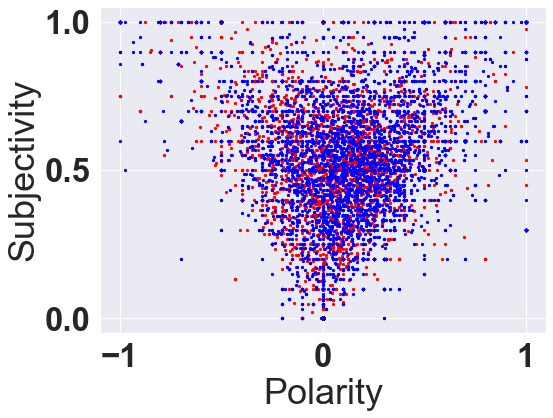

In [29]:
plt.figure(figsize=(8, 6))
plt.scatter(df_abuse['Polarity'], df_abuse['Subjectivity'],  s=5, color='red')
plt.scatter(df_recovered['Polarity'], df_recovered['Subjectivity'],  s=5, color='blue')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

## Prepare dui lexicons dictionary

In [31]:
import csv

def get_dui_dict(filename):
    d = {}
    with open(filename) as file_obj:
        reader_obj = csv.reader(file_obj)
        for row in reader_obj:
            term = row[0]
            rest = row[1:]
            d[term] = rest
    return d

dui_dict = get_dui_dict('categories.csv')
dui_dict

{'Term': ['L1', 'L2', 'L3', 'L4'],
 'abscesses': ['drug_use', 'health', '', ''],
 'track_marks': ['drug_use', 'health', '', ''],
 'abcess': ['drug_use', 'health', '', ''],
 'scar_tissue': ['drug_use', 'health', '', ''],
 'collapsed_veins': ['drug_use', 'health', '', ''],
 'trackmark': ['drug_use', 'health', '', ''],
 'narcan': ['drug_use', 'health', '', ''],
 'narcanned': ['drug_use', 'health', '', ''],
 'narcanning': ['drug_use', 'health', '', ''],
 'od': ['drug_use', 'using', '', ''],
 'oded': ['drug_use', 'using', '', ''],
 'overdosed': ['drug_use', 'health', '', ''],
 'overdose': ['drug_use', 'health', 'overdose', ''],
 'histamine_reaction': ['drug_use', 'health', '', ''],
 'accord': ['drug_use', 'acquisition', 'prescription', ''],
 'actavis': ['drug_use', 'acquisition', 'prescription', ''],
 'agora': ['drug_use', 'acquisition', 'darknet', ''],
 'alldaychemist': ['drug_use', 'acquisition', 'prescription', ''],
 'alphabay': ['drug_use', 'acquisition', 'darknet', ''],
 'bitcoin': ['d

In [32]:
drug_terms = []
drug_recovery = []
drug_use = []
for term, l in dui_dict.items():
    if l[0] == 'drug_terms':
        drug_terms.append(term)
    elif l[0] == 'drug_use':
        drug_use.append(term)
    elif l[0] == 'drug_recovery':
        drug_recovery.append(term)
drug_recovery

['clinics',
 'methadone_clinics',
 'abuse_counseling',
 'abuse_counselor',
 'addicts',
 'addicts_alcoholics',
 'alcholics',
 'alcoholics',
 'amitriptyline',
 'amitryptiline',
 'baclofen',
 'bupropion',
 'bupropion_wellbutrin',
 'buproprion',
 'deprenyl',
 'valdoxan',
 'welbutrin',
 'wellbutrin',
 'ambien',
 'amytal',
 'ativan',
 'barbital',
 'benzo',
 'benzodiazapines',
 'benzodiazepenes',
 'benzodiazepine',
 'benzodiazepines',
 'benzodiazipines',
 'benzodiazpines',
 'benzoes',
 'benzos',
 'bromazepam',
 'buspar',
 'bzd',
 'chlordiazepoxide',
 'clonazepam',
 'clonezepam',
 'clonopin',
 'clonzepam',
 'diaz',
 'flexeril',
 'gabapentin',
 'k_pins',
 'klonazepam',
 'klonipin',
 'klonopin',
 'klonopin_valium',
 'klonopins',
 'kpin',
 'kpin_valium',
 'kpins',
 'lorazepam',
 'lyrica',
 'nitrazepam',
 'oxazepam',
 'pregabalin',
 'valium',
 'valium_ativan',
 'valium_diazepam',
 'valium_klonopin',
 'valium_xanax',
 'vallium',
 'valuim',
 'xanax',
 'xanax_ativan',
 'xanax_klonopin',
 'xanax_valiu

In [33]:
# Not using stemmed dui dict this time
# def get_stem_dui_dict(dui_dict):
#     d = {}
#     for term, l in dui_dict.items():
#         d[ps.stem(term)] = l
#     return d
# stem_dui_dict = get_stem_dui_dict(dui_dict)
# print(len(stem_dui_dict))
# print(len(dui_dict))

## Populate dui category information to each tweet (add DUI terms, L1, L2, L3, L4 cols)

In [34]:
def populate_category(df):
    l1_l = []
    l2_l = []
    l3_l = []
    l4_l = []
    dui_l = []
    category = {''}
    for l in df['Tokenized list']:
        dui, l1, l2, l3, l4 = [], [], [], [], []
        for word in l:
            if word in dui_dict:
                dui.append(word)
                category = dui_dict[word]
                l1.append(category[0])
                if category[1]:
                    l2.append(category[1])
                if category[2]:
                    l3.append(category[2])
                if category[3]:
                    l4.append(category[3])
        l1_l.append(l1)
        l2_l.append(l2)
        l3_l.append(l3)
        l4_l.append(l4)
        dui_l.append(dui)
    df['DUI terms'] = dui_l
    df['L1'] = l1_l
    df['L2'] = l2_l
    df['L3'] = l3_l
    df['L4'] = l4_l

populate_category(df_recovered)
df_recovered.head(100)

Tweet  \
0     World Cup is in November December they would...   
1                                         Real Madrid   
2                            My guy what’s yur source   
3                    Lol and what was the goal pls😂😂😂   
4                 I Dey start Dey lose respect give u   
..                                                ...   
95                            https://t.co/Xg9TpRv5kU   
96            Lol whyimsingle https://t.co/H8mdhL2ZBd   
97    I stay as personally vague on social media a...   
98    Hence why I laughed. I don't take things lik...   
99   Hey, thanks. Unfortunately speaking with my p...   

                                       Tokenized list  Polarity  Subjectivity  \
0   [world, cup, november, december, would, voted,...  0.000000      0.000000   
1                                      [real, madrid]  0.200000      0.300000   
2                                  [guy, yur, source]  0.000000      0.000000   
3                                 [lol, goal, pls😂😂😂]  0.800000      0.700000   
4           [dey, start, dey, lose, respect, give, u]  0.000000      0.000000   
..                                                ...       ...           ...   
95                         [https, //t.co/xg9tprv5ku]  0.000000      0.000000   
96       [lol, whyimsingle, https, //t.co/h8mdhl2zbd]  0.800000      0.700000   
97  [stay, personally, vague, social, media, possi... -0.155556      0.522222   
98  [hence, laughed, n't, take, things, like, seri...  0.183333      0.433333   
99  [hey, thanks, unfortunately, speaking, parents... -0.150000      0.600000   

   DUI terms          L1         L2                       L3  L4  
0         []          []         []                       []  []  
1         []          []         []                       []  []  
2         []          []         []                       []  []  
3         []          []         []                       []  []  
4         []          []         []                       []  []  
..       ...         ...        ...                      ...  ..  
95        []          []         []                       []  []  
96        []          []         []                       []  []  
97  [social]  [drug_use]  [effects]  [increased sociability]  []  
98        []          []         []                       []  []  
99        []          []         []                       []  []  

[100 rows x 9 columns]

In [35]:
populate_category(df_abuse)
df_abuse.head(100)

Tweet  \
0                            Uhhh what. Not seeing it   
1                                            RejectOZ   
2       As if anyone with a brain would say, Hey, ...   
3      The dreaded lethal giant rainbow colored ch...   
4         “Than” I guess you skipped too many classes   
..                                                ...   
95      "weird ass pfp" u mean gwen stacy from spi...   
96   yknow i was thinking we've been twitter mutua...   
97      1 follower dudes with the most stone cold ...   
98                    i kiss women with good opinions   
99                                     im sorry women   

                                       Tokenized list  Polarity  Subjectivity  \
0                                      [uhhh, seeing]  0.000000      0.000000   
1                                          [rejectoz]  0.000000      0.000000   
2   [anyone, brain, would, say, hey, ya, great, id...  0.460000      0.250000   
3   [dreaded, lethal, giant, rainbow, colored, cha...  0.175000      0.850000   
4                     [guess, skipped, many, classes]  0.500000      0.500000   
..                                                ...       ...           ...   
95  [``, weird, ass, pfp, '', u, mean, gwen, stacy... -0.075357      0.784643   
96  [yknow, thinking, 've, twitter, mutuals, quite... -0.245833      0.440278   
97  [1, follower, dudes, stone, cold, takes, time,...  0.080000      0.640000   
98                      [kiss, women, good, opinions]  0.700000      0.600000   
99                                 [im, sorry, women] -0.500000      1.000000   

            DUI terms                      L1                   L2  \
0                  []                      []                   []   
1                  []                      []                   []   
2         [happiness]              [drug_use]            [effects]   
3   [chalk, officers]  [drug_terms, drug_use]  [stimulants, legal]   
4           [classes]         [drug_recovery]            [therapy]   
..                ...                     ...                  ...   
95                 []                      []                   []   
96                 []                      []                   []   
97             [cold]         [drug_recovery]         [withdrawal]   
98                 []                      []                   []   
99                 []                      []                   []   

                       L3                              L4  
0                      []                              []  
1                      []                              []  
2              [euphoria]                              []  
3                      []                              []  
4      [therapy_activity]                              []  
..                    ...                             ...  
95                     []                              []  
96                     []                              []  
97  [withdrawal_symptoms]  [physical_withdrawal_symptoms]  
98                     []                              []  
99                     []                              []  

[100 rows x 9 columns]

## Get frequency of dui terms

75824 1966
71419 2182


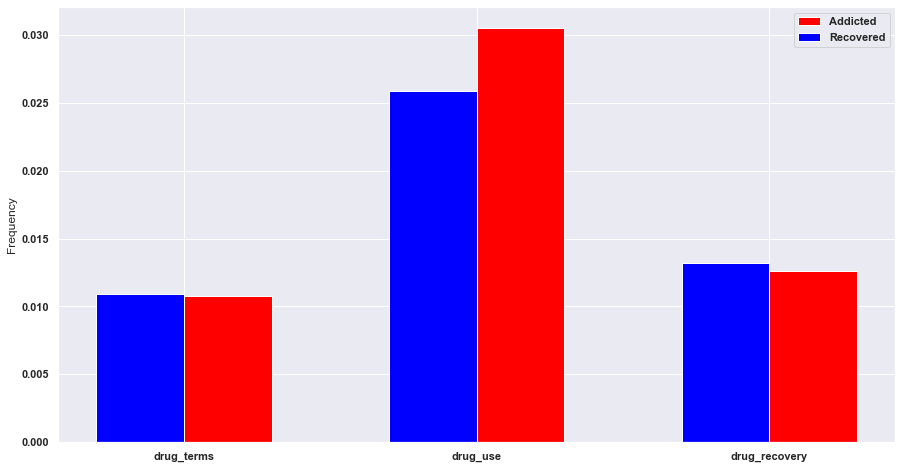

In [53]:
all = []
for l in df_recovered['L1']:
    all += l
n_terms = sum([len(token_list) for token_list in df_recovered['Tokenized list']])
recovered_dui_distribution = [all.count('drug_terms')/n_terms, all.count('drug_use')/n_terms, all.count('drug_recovery')/n_terms]
print(n_terms, all.count('drug_use'))

all = []
for l in df_abuse['L1']:
    all += l
m_terms = sum([len(token_list) for token_list in df_abuse['Tokenized list']])
print(m_terms, all.count('drug_use'))
abuse_dui_distribution = [all.count('drug_terms')/m_terms, all.count('drug_use')/m_terms, all.count('drug_recovery')/m_terms]

labels = ['drug_terms', 'drug_use', 'drug_recovery']
x = numpy.arange(3)
width = 0.3
  
plt.figure(figsize=(15, 8))
plt.bar(x + width/2, abuse_dui_distribution, width, label='Addicted', color='red')
plt.bar(x - width/2, recovered_dui_distribution, width, label='Recovered', color='blue')
plt.xticks(x, labels)
plt.ylabel("Frequency")
plt.legend()
plt.show()

## Get frequency of all terms

In [54]:
def frequency_list(df):
    all = []
    for l in df['DUI terms']:
        all += l
    x = numpy.array(all)
    values, counts = numpy.unique(x, return_counts=True)
    l = list(zip(values, counts))
    l.sort(key=lambda x:x[1], reverse=True)
    return l

recovered_frequency_list = frequency_list(df_recovered)

In [55]:
abuse_frequency_list = frequency_list(df_abuse)
abuse_frequency_list

[('high', 149),
 ('na', 98),
 ('money', 82),
 ('pain', 78),
 ('stop', 68),
 ('dxm', 64),
 ('party', 56),
 ('house', 50),
 ('happy', 42),
 ('pay', 40),
 ('covid', 39),
 ('government', 38),
 ('law', 35),
 ('overdose', 35),
 ('sad', 34),
 ('scared', 30),
 ('court', 29),
 ('addict', 28),
 ('cannabis', 28),
 ('opioid', 27),
 ('sick', 27),
 ('social', 27),
 ('hit', 26),
 ('medical', 26),
 ('tired', 25),
 ('energy', 24),
 ('alcohol', 22),
 ('drink', 22),
 ('angry', 20),
 ('bitcoin', 20),
 ('hospital', 20),
 ('afraid', 19),
 ('crying', 19),
 ('smart', 19),
 ('heroin', 18),
 ('medicine', 18),
 ('prison', 18),
 ('shot', 18),
 ('addiction', 17),
 ('doctors', 17),
 ('line', 17),
 ('paid', 17),
 ('running', 17),
 ('school', 17),
 ('bag', 16),
 ('blue', 16),
 ('cancer', 16),
 ('clean', 16),
 ('doctor', 16),
 ('marijuana', 16),
 ('omg', 16),
 ('smoke', 16),
 ('sober', 16),
 ('paying', 15),
 ('assault', 14),
 ('devil', 14),
 ('dose', 14),
 ('fentanyl', 14),
 ('insane', 14),
 ('prescription', 14),
 ('s

In [56]:
recovered_frequency_list = frequency_list(df_recovered)
recovered_frequency_list

[('na', 144),
 ('happy', 111),
 ('stop', 102),
 ('money', 86),
 ('twitching', 71),
 ('pay', 60),
 ('school', 54),
 ('sober', 45),
 ('hit', 44),
 ('high', 43),
 ('clean', 42),
 ('house', 40),
 ('sick', 40),
 ('heroin', 38),
 ('pain', 34),
 ('fire', 32),
 ('boy', 31),
 ('sad', 30),
 ('addict', 29),
 ('government', 28),
 ('addiction', 26),
 ('consent', 26),
 ('drink', 26),
 ('omg', 26),
 ('afraid', 25),
 ('alcohol', 25),
 ('court', 25),
 ('illegal', 25),
 ('covid', 24),
 ('rock', 24),
 ('insane', 23),
 ('line', 22),
 ('party', 22),
 ('prison', 21),
 ('running', 21),
 ('legal', 20),
 ('scared', 20),
 ('tired', 20),
 ('blue', 19),
 ('fentanyl', 19),
 ('insurance', 18),
 ('law', 18),
 ('medical', 18),
 ('paid', 18),
 ('smoke', 18),
 ('crying', 16),
 ('meth', 16),
 ('paying', 16),
 ('recovery', 16),
 ('social', 16),
 ('afford', 15),
 ('cocaine', 15),
 ('roll', 15),
 ('aa', 14),
 ('brandy', 14),
 ('broke', 14),
 ('mat', 14),
 ('peace', 14),
 ('quit', 14),
 ('shot', 14),
 ('stopped', 14),
 ('dr

In [57]:
abuse_topk_terms = [word for word, freq in abuse_frequency_list[:50]]
recovered_taopk_terms = [word for word, freq in recovered_frequency_list[:50]]

## Word2vec

In [58]:
import gensim

min_count = 5

abuse_tokens = df_abuse['Tokenized list'].values.tolist()
abuse_model = gensim.models.Word2Vec(abuse_tokens, min_count=min_count, vector_size=32)

recovered_tokens = df_recovered['Tokenized list'].values.tolist()
recovered_model = gensim.models.Word2Vec(recovered_tokens, min_count=min_count, vector_size=32)

In [59]:
abuse_model.wv.most_similar('hope') 

[('anything', 0.9992870688438416),
 ('medical', 0.9992679953575134),
 ('never', 0.9991794228553772),
 ("'s", 0.9991727471351624),
 ('...', 0.9991605877876282),
 ('old', 0.9991483092308044),
 ('hard', 0.9991320967674255),
 ('want', 0.9991313815116882),
 ('thing', 0.999130368232727),
 ('always', 0.9991214871406555)]

In [60]:
recovered_model.wv.most_similar('hope') 

[('little', 0.9989240169525146),
 ('lol', 0.9988983273506165),
 ('still', 0.9988961815834045),
 ('great', 0.9988868236541748),
 ('baby', 0.9988377094268799),
 ('heart', 0.9987514019012451),
 ('since', 0.9987506866455078),
 ('actually', 0.9987491965293884),
 ('got', 0.9987332820892334),
 ('saying', 0.998664915561676)]

## PCA (uncomment lines to draw words in other categories)

No handles with labels found to put in legend.


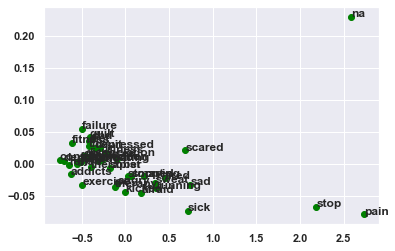

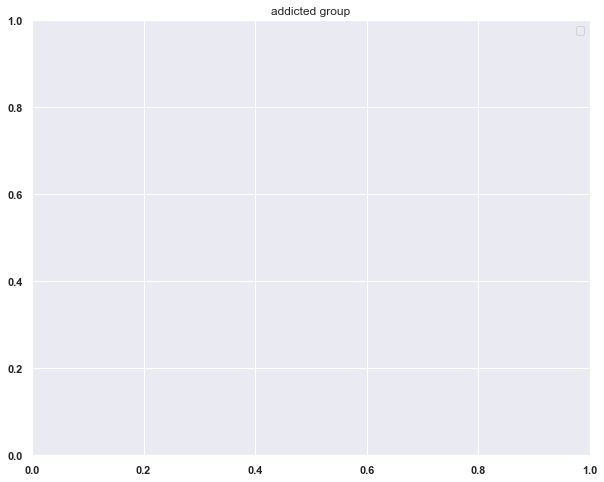

In [63]:
from sklearn.decomposition import PCA

positive_terms = ['hope', 'wisdom', 'courage', 'happy', 'dream', 'love', 'courageous', 'perseverance', 'thanks', 'grateful', 'confident', 'good', 'nice', 'best', 'faith', 'hoping', 'appreciate', 'control', 'blessings', 'blessing']
negative_terms = ['pain', 'hurt', 'anxious', 'anxiety', 'depressed', 'sad', 'hate']


def get_pca_result_and_draw(model, selected_terms, color, label, show_label=True):
    vocab = list(model.wv.key_to_index)
    vocab = [v for v in vocab if v in selected_terms]
    d = {}
    for word in vocab:
        d[word] = model.wv[word]
    words = list(d.keys())
    vectors = list(d.values())
    word_vectors = numpy.array(vectors)
    result = PCA(n_components=2).fit_transform(word_vectors)
    plt.scatter(result[:, 0], result[:, 1], color=color, label=label)
    if show_label:
        for i, word in enumerate(words):
            plt.annotate(word, xy=(result[i, 0], result[i, 1]))

    
# get_pca_result_and_draw(abuse_model, drug_terms, 'gray', 'drug_terms')
get_pca_result_and_draw(abuse_model, drug_recovery, 'green', 'drug_recovery')
# get_pca_result_and_draw(abuse_model, drug_use, 'red', 'drug_use')

# get_pca_result_and_draw(abuse_model, positive_terms, 'green', 'positive_terms')
# get_pca_result_and_draw(abuse_model, negative_terms, 'red', 'negative_terms')

plt.legend()
plt.title('addicted group')
plt.show()

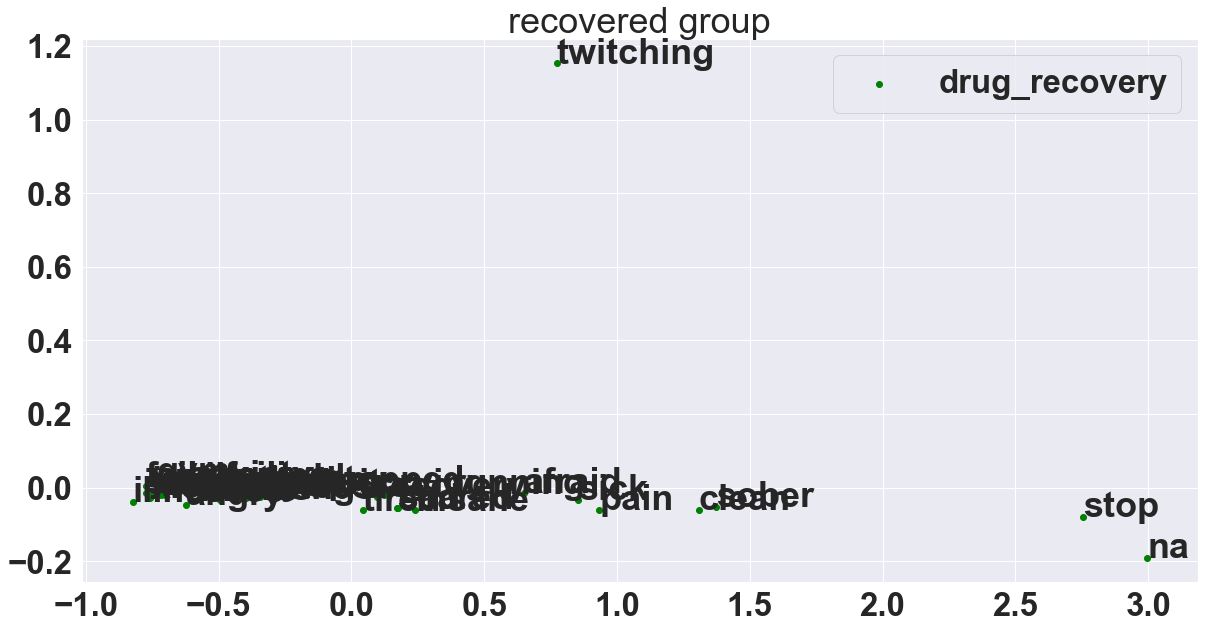

In [359]:
get_pca_result_and_draw(recovered_model, drug_recovery, 'green', 'drug_recovery')
plt.legend()
plt.title('recovered group')
plt.show()

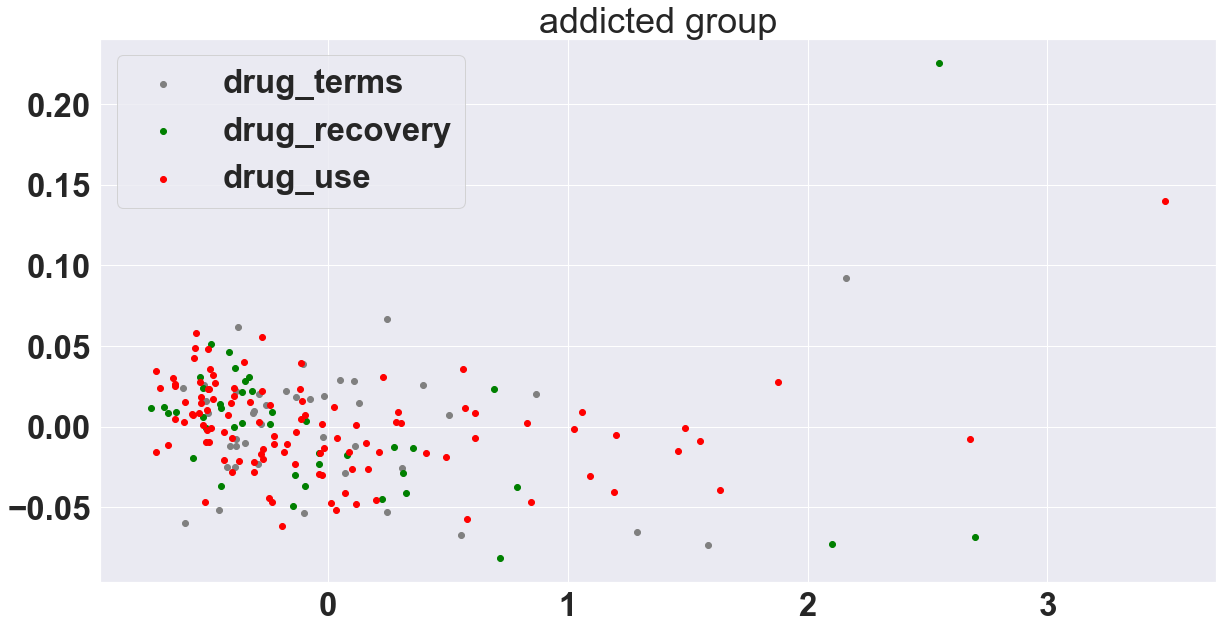

In [353]:
get_pca_result_and_draw(abuse_model, drug_terms, 'gray', 'drug_terms', show_label=False)
get_pca_result_and_draw(abuse_model, drug_recovery, 'green', 'drug_recovery', show_label=False)
get_pca_result_and_draw(abuse_model, drug_use, 'red', 'drug_use', show_label=False)

plt.legend()
plt.title('addicted group')
plt.show()

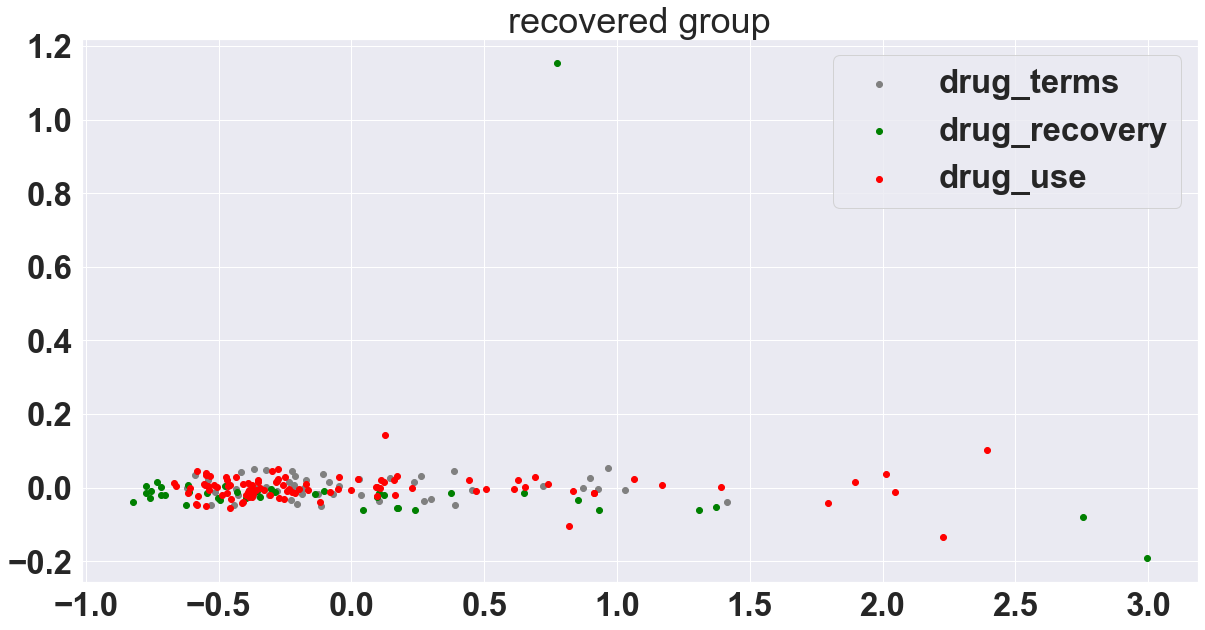

In [346]:
get_pca_result_and_draw(recovered_model, drug_terms, 'gray', 'drug_terms', show_label=False)
get_pca_result_and_draw(recovered_model, drug_recovery, 'green', 'drug_recovery', show_label=False)
get_pca_result_and_draw(recovered_model, drug_use, 'red', 'drug_use', show_label=False)

# get_pca_result_and_draw(recovered_model, positive_terms, 'green', 'positive_terms')
# get_pca_result_and_draw(recovered_model, negative_terms, 'red', 'negative_terms')

plt.legend()
plt.title('recovered group')
plt.show()

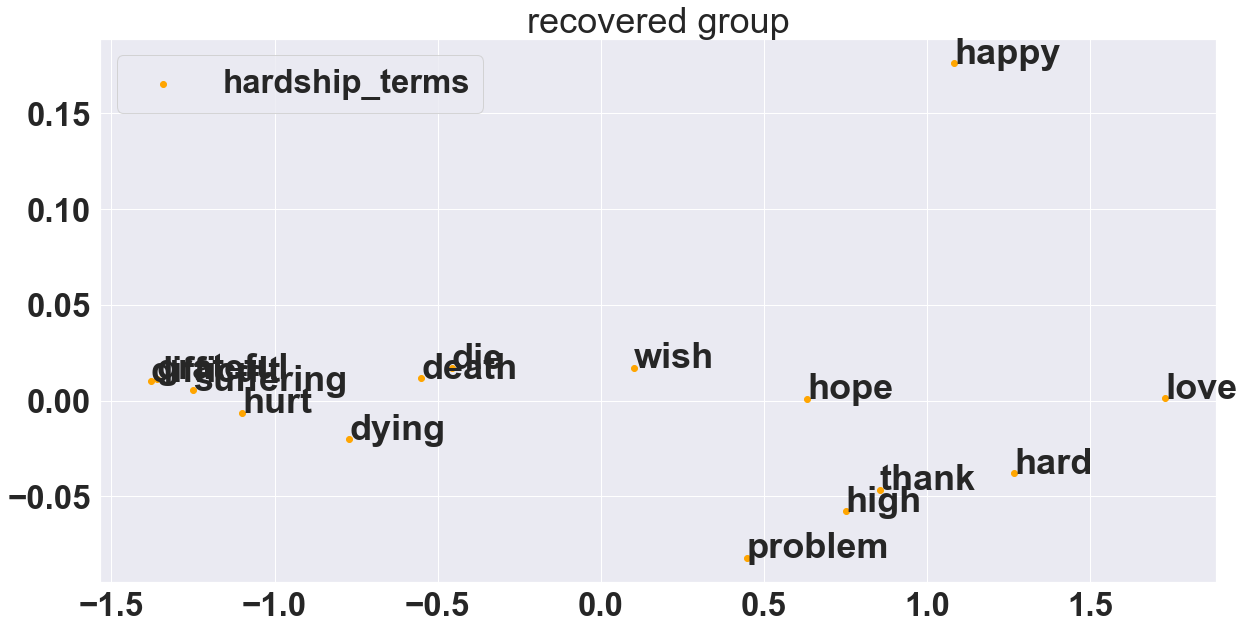

In [347]:
hardship_terms = ['misery', 'distress', 'problem', 'hard', 'suffering', 'hurt', 'high', 'grateful', 'thank', 'appreciate' 'glad', 'hope', 'wish', 'difficult', 'difficulty', 'love', 'happy', 'death', 'die', 'dying']

get_pca_result_and_draw(recovered_model, hardship_terms, 'orange', 'hardship_terms')
plt.legend()
plt.title('recovered group')
plt.show()

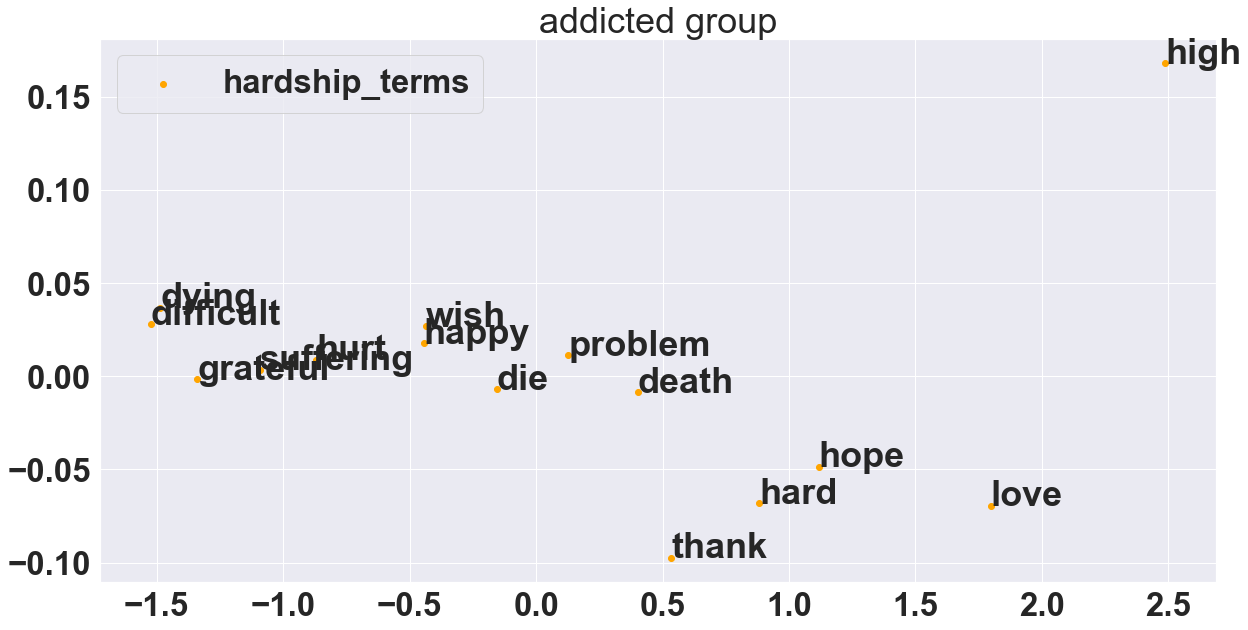

In [348]:
get_pca_result_and_draw(abuse_model, hardship_terms, 'orange', 'hardship_terms')
plt.legend()
plt.title('addicted group')
plt.show()

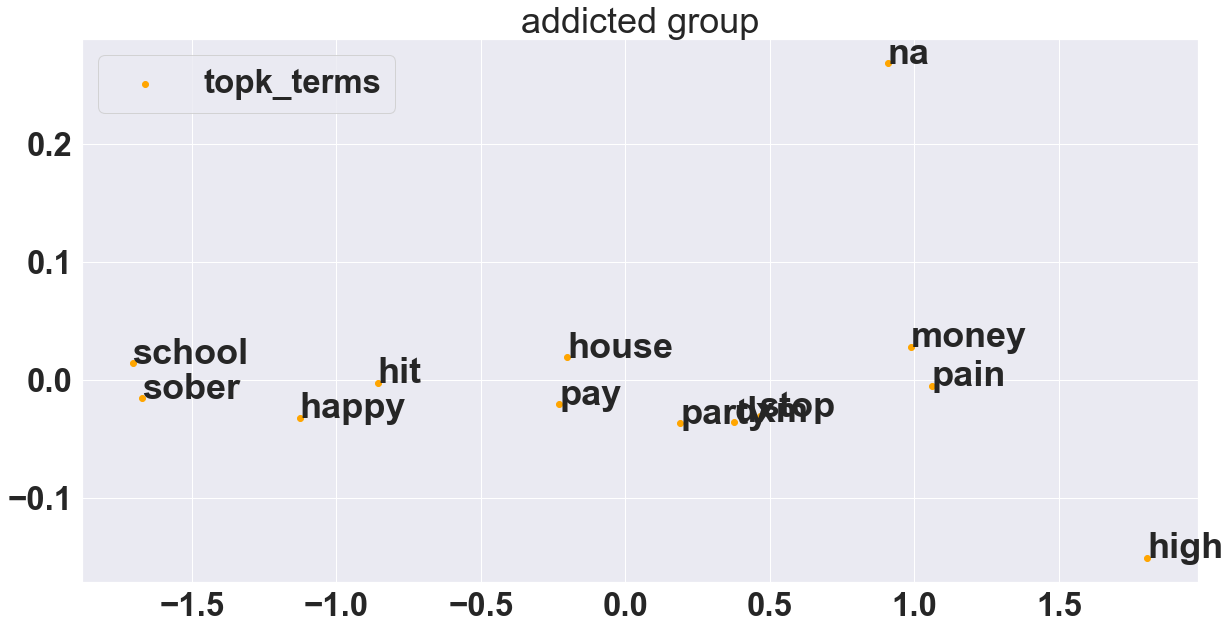

In [349]:
abuse_topk_terms = [word for word, freq in frequency_list(df_abuse)[:10]]
recovered_topk_terms = [word for word, freq in frequency_list(df_recovered)[:10]]
topk_terms = [e for e in abuse_topk_terms + recovered_topk_terms if e != 'amp']

get_pca_result_and_draw(abuse_model, topk_terms, 'orange', 'topk_terms')
plt.legend()
plt.title('addicted group')
plt.show()

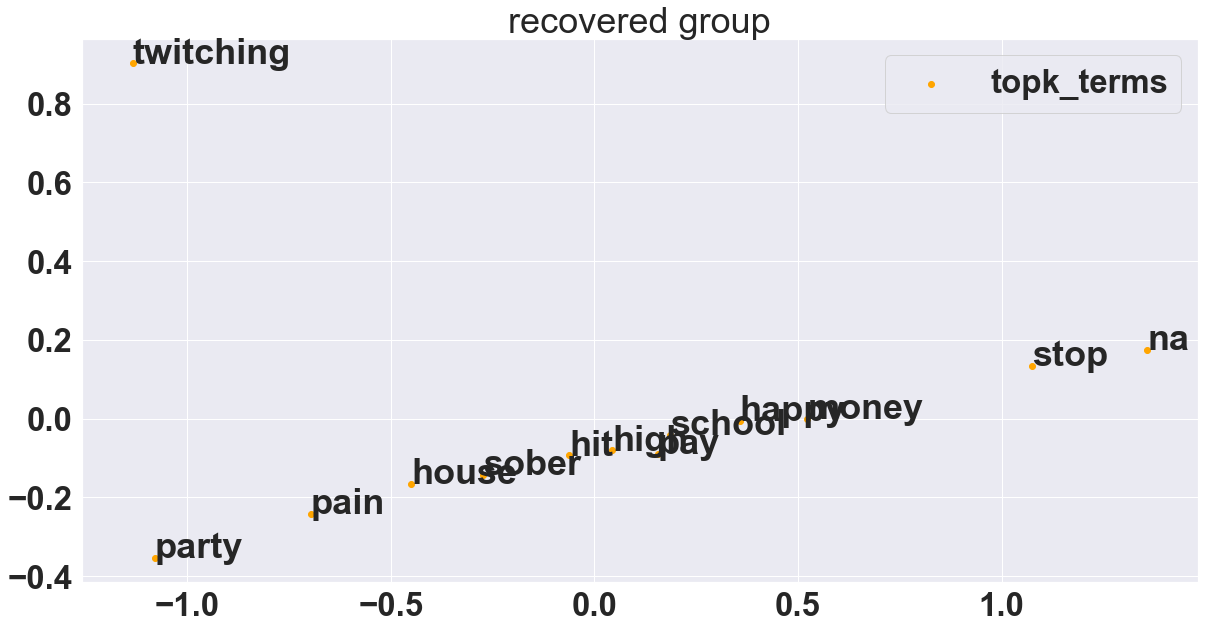

In [351]:
get_pca_result_and_draw(recovered_model, topk_terms, 'orange', 'topk_terms')    
plt.legend()
plt.title('recovered group')
plt.show()

In [373]:
recovered_model.wv.similarity('grateful', 'difficult')

0.9895902

In [374]:
abuse_model.wv.similarity('grateful', 'difficult')

0.96057504